# 参数配置

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# import syft as sy
# import copy
# hook = sy.TorchHook(torch)

In [3]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
# # create a couple workers
# bob = sy.VirtualWorker(hook, id="bob")
# alice = sy.VirtualWorker(hook, id="alice")
# secure_worker_a = sy.VirtualWorker(hook, id="secure_worker_a")
# secure_worker_b = sy.VirtualWorker(hook, id="secure_worker_b")

In [5]:
# transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       # transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std
 

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std


# choose the training and test datasets

# federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
#     datasets.CIFAR100('/home/zhaojia-raoxy/data', train=True, download=True,
#                    transform=train_transforms)
#     .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
#     batch_size=20, shuffle=True, **kwargs)


# federated_test_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
#     datasets.CIFAR100('/home/zhaojia-raoxy/data', train=False, download=True,
#                    transform=test_transforms)
#     .federate((secure_worker_a, secure_worker_b)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
#     batch_size=20, shuffle=False, **kwargs)

In [6]:
federated_train_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader
    datasets.CIFAR10('/home/zhaojia-raoxy/data', train=True, download=True,
                   transform=train_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=True, **kwargs)


federated_test_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader
    datasets.CIFAR10('/home/zhaojia-raoxy/data', train=False, download=True,
                   transform=test_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


# ResNet18

In [7]:
model_name = '/home/zhaojia-raoxy/model/resnet18-5c106cde.pth'

def ResNet_s(model_name):
    ''':cvar
    返回修改好的模型，和冻结好的参数
    '''
    from torchvision.models import resnet18
    pretrain_model = resnet18(pretrained=False)
    pretrain_model.fc = nn.Linear(pretrain_model.fc.in_features, 100)  # 将全连接层改为自己想要的分类输出
    pretrained_dict = torch.load(model_name)

    pretrained_dict.pop('fc.weight')
    pretrained_dict.pop('fc.bias')

    model_dict = pretrain_model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

    model_dict.update(pretrained_dict)  # 模型参数列表进行参数更新，加载参数
    pretrain_model.load_state_dict(model_dict)  # 将满足条件的参数的 requires_grad 属性设置为False

#     for name, value in pretrain_model.named_parameters():
#         if (name != 'fc.weight') and (name != 'fc.bias'):
#             value.requires_grad = False
    params_conv = filter(lambda p: p.requires_grad, pretrain_model.parameters())  # 要更新的参数在parms_conv当中
    return pretrain_model, params_conv

model, params_conv = ResNet_s(model_name)
model = model.to(device)
# optimizer = optim.SGD(params_conv, lr=0.03) # TODO momentum is not supported at the moment
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4) #添加权重衰减（weight decay）作为正则化项，限制模型参数的大小。

# 训练

In [8]:
criterion = nn.CrossEntropyLoss().to(device)

In [9]:
loss_test=[]
acc_test=[]
def test(model, device, federated_test_loader, batch_size):
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
#             model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            data, target = data.to(device), target.to(device)
            output = model(data)
            n += target.shape[0]
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
#             model.get()
#             test_loss += loss.get() # sum up batch loss
            test_loss += loss.item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # print("{}\t{}".format(correct,target.shape))

    test_loss /= len(federated_test_loader)
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/n)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))

In [10]:
loss_train=[]
acc_train=[]

def train(model, device, federated_train_loader, optimizer, epoch, batch_size):
    global criterion,txt,loss_train,acc_train
    model.train()
    train_loss = 0
    correct = 0
    n=0
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
#         model.send(data.location) # <-- NEW: send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        n += target.shape[0]
        loss = criterion(output, target.long())
#         loss = F.cross_entropy(output, target.long())
#         loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
#         model.get() # <-- NEW: get the model back
        pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        # print("{}\t{}".format(correct,target.shape))
        train_loss+=loss.item()

    train_loss /= len(federated_train_loader)
    loss_train.append(train_loss)
    acc_train.append(correct*1.0/ n)

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    train_loss, correct, len(federated_train_loader) * batch_size,
     100.*correct / n))

In [11]:
for epoch in range(500):
    train(model, device, federated_train_loader, optimizer, epoch, batch_size=200)
    test(model, device, federated_test_loader, batch_size=200)

Train set: Average loss: 1.2908, Accuracy: 28840/50000 (58%)
Test set: Average loss: 0.9042, Accuracy: 6850/10000 (68%)
Train set: Average loss: 0.7528, Accuracy: 36869/50000 (74%)
Test set: Average loss: 0.7943, Accuracy: 7229/10000 (72%)
Train set: Average loss: 0.5823, Accuracy: 39875/50000 (80%)
Test set: Average loss: 0.7473, Accuracy: 7428/10000 (74%)
Train set: Average loss: 0.4611, Accuracy: 42048/50000 (84%)
Test set: Average loss: 0.7337, Accuracy: 7577/10000 (76%)
Train set: Average loss: 0.3567, Accuracy: 43900/50000 (88%)
Test set: Average loss: 0.7512, Accuracy: 7567/10000 (76%)
Train set: Average loss: 0.2662, Accuracy: 45586/50000 (91%)
Test set: Average loss: 0.7760, Accuracy: 7604/10000 (76%)
Train set: Average loss: 0.1925, Accuracy: 46898/50000 (94%)
Test set: Average loss: 0.8176, Accuracy: 7637/10000 (76%)
Train set: Average loss: 0.1355, Accuracy: 47963/50000 (96%)
Test set: Average loss: 0.8769, Accuracy: 7621/10000 (76%)
Train set: Average loss: 0.0917, Accurac

# 结果保存

In [12]:
save_name='ResNet18-no-fed'

In [13]:
# 保存模型的权重
torch.save(model.state_dict(), "/home/zhaojia-raoxy/model/out/{}.pt".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/out/{}.pt".format(save_name))

保存文件： /home/zhaojia-raoxy/model/out/ResNet18-no-fed.pt


In [14]:
# 保存整个模型
torch.save(model, "/home/zhaojia-raoxy/model/out/{}.h5".format(save_name))
print("保存文件：","/home/zhaojia-raoxy/model/out/{}.h5".format(save_name))

保存文件： /home/zhaojia-raoxy/model/out/ResNet18-no-fed.h5


# 分析

In [15]:
import matplotlib as mpl
from matplotlib import pyplot as plt

In [16]:
import pandas as pd
df=pd.DataFrame([loss_train, loss_test, acc_train, acc_test]).T
df.columns =['loss_train', 'loss_test','acc_train','acc_test']
df.to_csv("/home/zhaojia-raoxy/files/{}".format(save_name),index=False)

<IPython.core.display.Javascript object>


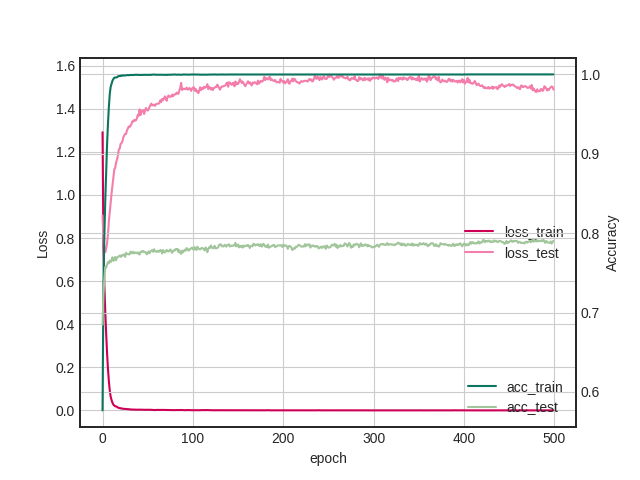

In [20]:
mpl.use('nbAgg')
mpl.style.use('seaborn-white')

# 将DataFrame中的数据进行可视化，设置两个y轴
ax = df[['loss_train', 'loss_test']].plot(color=['#CD0056','#F47EAB'])
# 创建一个新的Axes对象，共享x轴
ax2 = ax.twinx()
# 绘制'acc_train'和'acc_test'在右侧y轴
df[['acc_train', 'acc_test']].plot(ax=ax2, color=['#0C755F', '#A2C69B'])
# 设置左侧y轴标签
ax.set_ylabel('Loss')
ax.set_xlabel('epoch')
# 设置右侧y轴标签
ax2.set_ylabel('Accuracy')
ax.grid(True)
ax2.grid(True)

# 显示图形
plt.show()